# **Module 1: Spatial Dependence and Regression**

#### Data
For this workshop, data are created and saved to the directory `./data-module-1/`.
- `mnp.shp` -  a pseudo dataset representing hypothetical pest stress for selected Minnesota counties.

#### Software
To execute the code you will need a Python environment with the packages imported below. The default environment does not have all required packages to execute this script. Therefore, run the following command beforehand to install `PySAL` (Python Spatial Analysis Library: http://pysal.org/pysal/index.html):
- `pip install pysal --user`

In [1]:
# general use packages
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as statsmodels

# geospatial packages
import geopandas as gpd
from libpysal import weights
import esda
import spreg
from splot.esda import plot_moran, plot_local_autocorrelation
from splot.libpysal import plot_spatial_weights

import os
os.environ['PROJ_LIB'] = '/opt/conda/envs/user_default/share/proj'

### **Explore input data**

In [2]:
mnp = gpd.read_file("./data-module-1/mnp.shp")
print (f"Coordinate reference system is {mnp.crs}")
print (f"Number of records is {len(mnp)}")
mnp.head()

Coordinate reference system is EPSG:26915
Number of records is 41


,COUNTYFIPS,COUNTYNAME,HOST,PEST,geometry
0,013,Blue Earth,7.070996,101.373005,"POLYGON ((390506.856 4902151.077, 390511.850 4..."
1,015,Brown,5.333409,87.899395,"POLYGON ((358342.018 4924074.276, 358342.521 4..."
2,019,Carver,5.926490,45.360617,"POLYGON ((439502.612 4980761.193, 439476.618 4..."
3,023,Chippewa,5.664981,74.068789,"POLYGON ((323409.909 5002337.605, 323356.939 5..."
4,033,Cottonwood,5.659359,90.921421,"POLYGON ((303222.915 4896582.925, 304066.172 4..."


Text(0.5, 1.0, 'Minnesota Pest Pressure for selected counties')

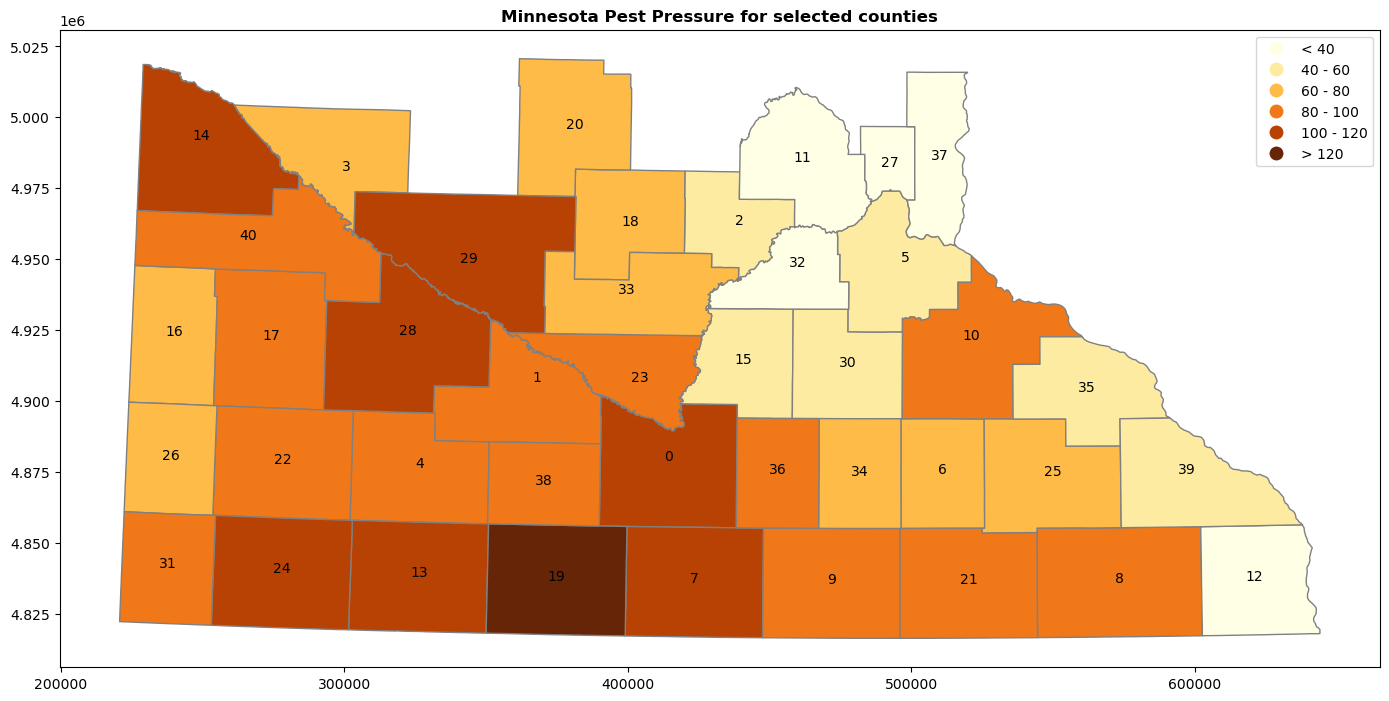

In [3]:
fig, ax = plt.subplots(figsize=(14,8), tight_layout=True)

mnp.plot(ax=ax, column="PEST", legend=True, scheme="User_Defined", cmap="YlOrBr", 
         edgecolor="grey", classification_kwds=dict(bins=[40,60,80,100,120]),
         legend_kwds={"labels": ["< 40", "40 - 60", "60 - 80", "80 - 100", "100 - 120", "> 120"]})
mnp["coords"] = mnp["geometry"].apply(lambda x: x.representative_point().coords[:])
mnp["coords"] = [coords[0] for coords in mnp["coords"]]
for idx, row in mnp.iterrows():
    ax.annotate(text=idx, xy=row["coords"], horizontalalignment="center")
ax.set_title("Minnesota Pest Pressure for selected counties", weight="bold")

### **Spatial weights**

#### How to define a neighbourhood in the form of spatial weights?

In [4]:
# calculate neighboring using Queen's case (contiguity)
mnp_nbq = weights.contiguity.Queen.from_dataframe(mnp, use_index=False)
# calculate neighboring using Rook's case (contiguity)
mnp_nbr = weights.contiguity.Rook.from_dataframe(mnp, use_index=False)
# calculate neighboring using K-nearest neighbors (distance-based)
mnp_nbk3 = weights.distance.KNN.from_dataframe(mnp, k=3)
# calculate neighboring by distance (distance-based)
mnp_nbd = weights.distance.DistanceBand.from_dataframe(mnp, 80000)

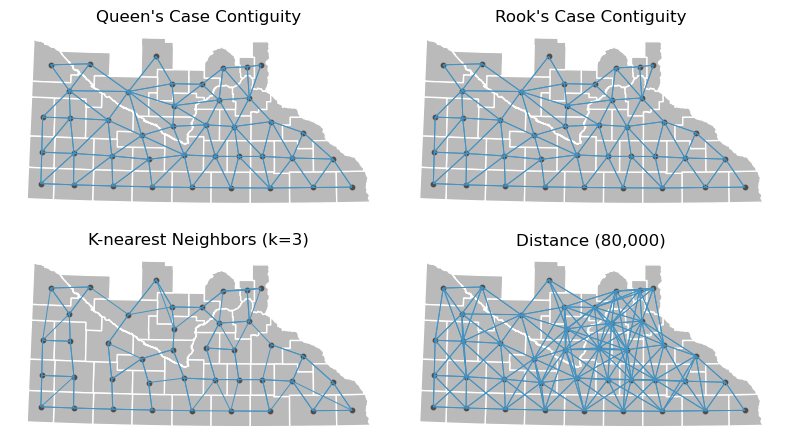

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), tight_layout=True)

plot_spatial_weights(mnp_nbq, mnp, ax=axs[0, 0])
axs[0, 0].set_title("Queen's Case Contiguity")

plot_spatial_weights(mnp_nbr, mnp, ax=axs[0, 1])
axs[0, 1].set_title("Rook's Case Contiguity")

plot_spatial_weights(mnp_nbk3, mnp, ax=axs[1, 0])
axs[1, 0].set_title("K-nearest Neighbors (k=3)")

plot_spatial_weights(mnp_nbd, mnp, ax=axs[1, 1])
axs[1, 1].set_title("Distance (80,000)")

plt.show()

#### Characterize a spatial weights matrix

In [6]:
print (f"Number of units: {mnp_nbd.n}")
print (f"Number of nonzero weights: {mnp_nbd.nonzero}")
print (f"Percentage of nonzero weights: {mnp_nbd.pct_nonzero}")
print (f"Average number of neighbors: {mnp_nbd.mean_neighbors}")
print (f"Largest number of neighbors is {mnp_nbd.max_neighbors}")
print (f"Minimum number of neighbors is {mnp_nbd.min_neighbors}")
print (f"Number of units without any neighbors {len(mnp_nbd.islands)}")
print (f"Neighbour list: {mnp_nbd.neighbors}")

Number of units: 41
Number of nonzero weights: 332
Percentage of nonzero weights: 19.750148720999405
Average number of neighbors: 8.097560975609756
Largest number of neighbors is 14
Minimum number of neighbors is 2
Number of units without any neighbors 0
Neighbour list: {0: [1, 7, 9, 15, 19, 23, 30, 33, 34, 36, 38], 1: [0, 4, 13, 18, 19, 23, 28, 29, 33, 38], 2: [5, 11, 15, 18, 20, 23, 27, 30, 32, 33, 37], 3: [14, 17, 28, 29, 40], 4: [1, 13, 17, 19, 22, 24, 28, 38], 5: [2, 6, 10, 11, 15, 27, 30, 32, 34, 35, 37], 6: [5, 8, 9, 10, 15, 21, 25, 30, 34, 35, 36], 7: [0, 9, 15, 19, 23, 34, 36, 38], 8: [6, 12, 21, 25, 35, 39], 9: [0, 6, 7, 21, 30, 34, 36], 10: [5, 6, 25, 27, 30, 32, 34, 35, 37], 11: [2, 5, 15, 18, 27, 30, 32, 33, 37], 12: [8, 39], 13: [1, 4, 19, 22, 24, 38], 14: [3, 16, 17, 40], 15: [0, 2, 5, 6, 7, 11, 18, 23, 30, 32, 33, 34, 36], 16: [14, 17, 22, 26, 40], 17: [3, 4, 14, 16, 22, 26, 28, 29, 40], 18: [1, 2, 11, 15, 20, 23, 29, 32, 33], 19: [0, 1, 4, 7, 13, 23, 38], 20: [2, 18, 2

#### Spatial weights transformation and weights summary
In this examples, we are setting transformations of weights and then computing an adjacency list representation of a weights object. Two different transforms are presented: `B` – Binary and `R` – Row-standardization.

In [7]:
# Spatial Weights Summary - Binary
mnp_nbd.set_transform("B")
mnp_nbd_lw_r = mnp_nbd.to_adjlist()
print (f"Weights: {mnp_nbd.weights}")
print ("Weights summary: ")
print (mnp_nbd_lw_r["weight"].describe())

Weights: {0: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 1: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 2: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 3: [1.0, 1.0, 1.0, 1.0, 1.0], 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 5: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 6: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 7: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 8: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 9: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 10: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 11: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 12: [1.0, 1.0], 13: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 14: [1.0, 1.0, 1.0, 1.0], 15: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 16: [1.0, 1.0, 1.0, 1.0, 1.0], 17: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 18: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 19: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 20: [1.0, 1.0, 1.0, 1.0], 21: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 22: [1.0

In [8]:
# Spatial Weights Summary - Row Standardized
mnp_nbd.set_transform("R")
mnp_nbd_lw_r = mnp_nbd.to_adjlist()
print (f"Weights: {mnp_nbd.weights}")
print ("Weights summary: ")
print (mnp_nbd_lw_r["weight"].describe())

Weights: {0: [0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091], 1: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 2: [0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091], 3: [0.2, 0.2, 0.2, 0.2, 0.2], 4: [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125], 5: [0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091], 6: [0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.0909

#### Spatial lag

In [9]:
mnp["PEST_lag"] = weights.spatial_lag.lag_spatial(mnp_nbd, mnp["PEST"])

In [10]:
mnp.head()

,COUNTYFIPS,COUNTYNAME,HOST,PEST,geometry,coords,PEST_lag
0,013,Blue Earth,7.070996,101.373005,"POLYGON ((390506.856 4902151.077, 390511.850 4...","(414405.4039109654, 4878925.029400001)",84.165829
1,015,Brown,5.333409,87.899395,"POLYGON ((358342.018 4924074.276, 358342.521 4...","(368092.2935817238, 4906849.559700001)",96.765858
2,019,Carver,5.926490,45.360617,"POLYGON ((439502.612 4980761.193, 439476.618 4...","(439486.8968293613, 4962343.0352)",52.196666
3,023,Chippewa,5.664981,74.068789,"POLYGON ((323409.909 5002337.605, 323356.939 5...","(300725.8847719185, 4981265.915050001)",107.100504
4,033,Cottonwood,5.659359,90.921421,"POLYGON ((303222.915 4896582.925, 304066.172 4...","(326827.0457292909, 4876589.717700003)",103.089106


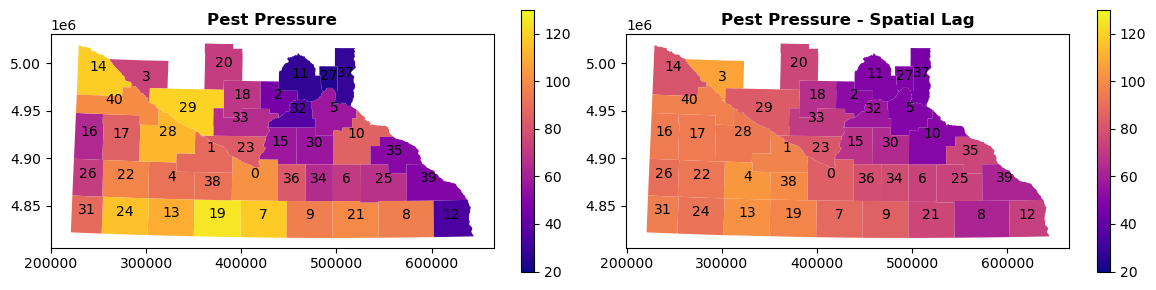

In [11]:
fig, axs = plt.subplots(1,2, figsize=(12,3), tight_layout=True)

mnp.plot(ax=axs[0], column="PEST", cmap="plasma", legend=True, vmin=20, vmax=130)
axs[0].set_title("Pest Pressure", weight="bold")

mnp.plot(ax=axs[1], column="PEST_lag", cmap="plasma", legend=True, vmin=20, vmax=130)
axs[1].set_title("Pest Pressure - Spatial Lag", weight="bold")

for idx, row in mnp.iterrows():
    axs[0].annotate(text=idx, xy=row["coords"], horizontalalignment="center")
    axs[1].annotate(text=idx, xy=row["coords"], horizontalalignment="center")

### **Spatial Autocorrelation**

Spatial autocorrelation measures the correlation of a variable with itself across space. Moran's I statistic is one of the most common measures of spatial autocorrelation. It allows to evaluate whether the pattern presented by the features is clustered, dispersed, or random.

#### Global Moran's I

In [12]:
mi = esda.Moran(mnp["PEST"], mnp_nbd)
print ("Moran's I statistic: {}".format(mi.I))
print ("p-value of I under randomization assumption: {}".format(mi.p_rand))
print ("variance of I under randomization assumption: {}".format(mi.VI_rand))
print ("Expected value under normality assumption: {}".format(mi.EI))

Moran's I statistic: 0.4290751190040858
p-value of I under randomization assumption: 1.6890728740791382e-09
variance of I under randomization assumption: 0.005679543034983935
Expected value under normality assumption: -0.025


/home/u01000486/.local/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


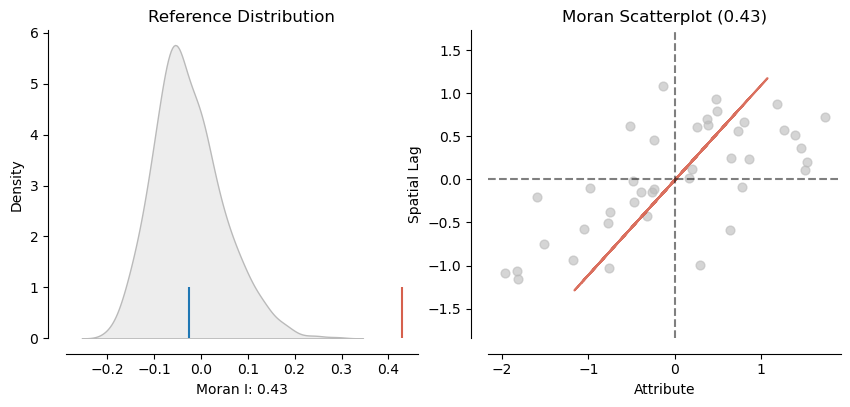

In [13]:
plot_moran(mi)
plt.show()

#### Local Moran's I

In [14]:
mi_loc = esda.Moran_Local(mnp["PEST"], mnp_nbd)
print ("Local Moran's I values: {}".format(mi_loc.Is))

Local Moran's I values: [ 0.20266127  0.25671278  1.07356882 -0.13743176  0.44214236  0.76187375
  0.03729538  0.51736469 -0.36809851  0.16177814 -0.28622864  1.89755981
  0.31968825  1.00517324  0.15340706  0.27718341 -0.31001478  0.15369759
  0.13609464  1.23269183  0.02460981 -0.06986878  0.40234884  0.02534386
  0.69634667  0.05662181 -0.10297014  2.08569759  0.70899111  0.29455257
  0.3789679   0.24067392  1.10440008  0.11900729  0.00871481  0.10159902
  0.00308639  2.05708658  0.37958149  0.59742745  0.52366714]


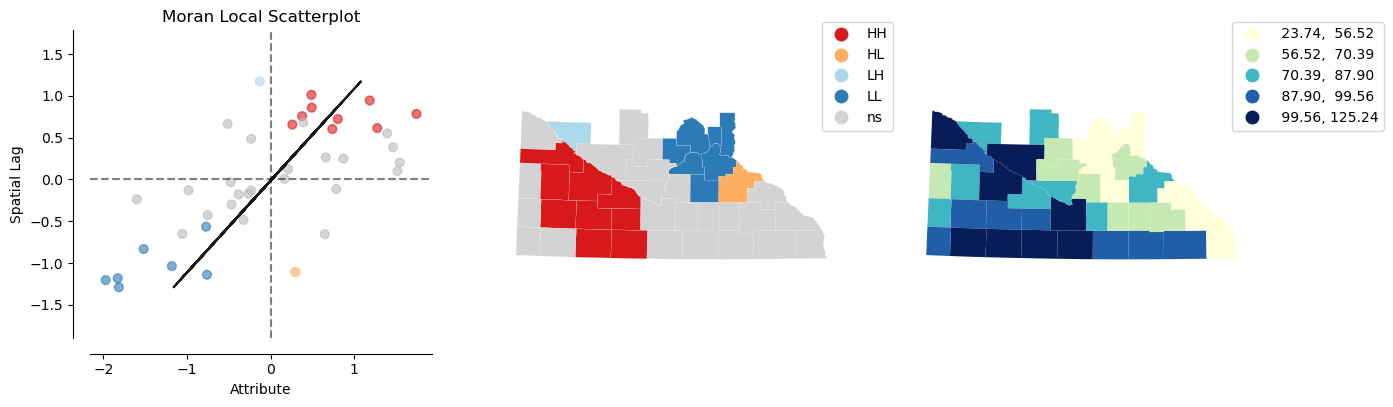

In [15]:
plot_local_autocorrelation(mi_loc, mnp, "PEST")
plt.show()

### **Spatial Regression Models**

#### Ordinary Least Squares model - NOT Spatial

In [16]:
# define dependent (response, or y) and independent (explanatory, or x) variables
y = mnp["PEST"].to_numpy()
x = mnp[["HOST"]].values

In [17]:
# adding the constant term
x_ = statsmodels.add_constant(x)
# performing the regression
# and fitting the model
result = statsmodels.OLS(y, x_).fit()
 # printing the summary table
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     7.737
Date:                Wed, 25 Oct 2023   Prob (F-statistic):            0.00829
Time:                        13:30:23   Log-Likelihood:                -190.07
No. Observations:                  41   AIC:                             384.1
Df Residuals:                      39   BIC:                             387.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.0175     16.531      1.997      0.0

#### Ordinary Least Squares model - WITH Spatial Diagnostics

In [18]:
mnp_ols = spreg.OLS(y, x, w=mnp_nbd, name_w="Distance based", name_x=["HOST"], name_y="PEST", 
                 name_ds="MN Pest Pressure", white_test=True, spat_diag=True, moran=True)
print(mnp_ols.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :MN Pest Pressure
Weights matrix      :Distance based
Dependent Variable  :        PEST                Number of Observations:          41
Mean dependent var  :     77.6361                Number of Variables   :           2
S.D. dependent var  :     27.6551                Degrees of Freedom    :          39
R-squared           :      0.1655
Adjusted R-squared  :      0.1441
Sum squared residual:     25527.9                F-statistic           :      7.7368
Sigma-square        :     654.562                Prob(F-statistic)     :    0.008292
S.E. of regression  :      25.584                Log likelihood        :    -190.073
Sigma-square ML     :     622.632                Akaike info criterion :     384.145
S.E of regression ML:     24.9526                Schwarz criterion     :     387.572

------------------------------------------------------

In [19]:
mi_ols = esda.Moran(mnp_ols.u, mnp_nbd)
print ("Moran's I statistic: {}".format(mi_ols.I))

Moran's I statistic: 0.36122882437972087


/home/u01000486/.local/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


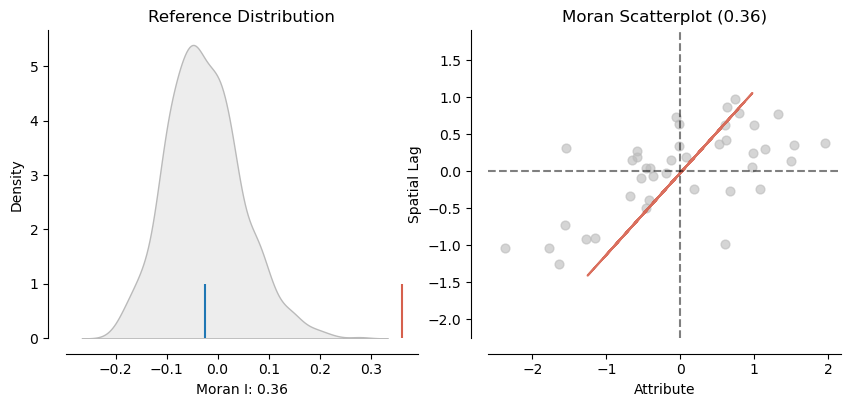

In [20]:
plot_moran(mi_ols)
plt.show()

#### ML estimation of the spatial error model

In [21]:
mnp_sem = spreg.ML_Error(y, x, w=mnp_nbd, name_w="Distance based", name_x=["HOST"], name_y="PEST", 
                   name_ds="MN Pest Pressure")
print(mnp_sem.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :MN Pest Pressure
Weights matrix      :Distance based
Dependent Variable  :        PEST                Number of Observations:          41
Mean dependent var  :     77.6361                Number of Variables   :           2
S.D. dependent var  :     27.6551                Degrees of Freedom    :          39
Pseudo R-squared    :      0.1655
Log likelihood      :   -182.7003
Sigma-square ML     :    388.4750                Akaike info criterion :     369.401
S.E of regression   :     19.7098                Schwarz criterion     :     372.828

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        47.060

/opt/conda/envs/user_default/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


#### ML estimation of the spatial lag model

In [22]:
mnp_slm = spreg.ML_Lag(y, x, w=mnp_nbd, name_w="Distance based", name_x=["HOST"], name_y="PEST", 
                 name_ds="MN Pest Pressure")
print ("Estimate of spatial autoregressive coefficient rho: {}".format(mnp_slm.rho))
print(mnp_slm.summary)

Estimate of spatial autoregressive coefficient rho: 0.7121615826389838
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :MN Pest Pressure
Weights matrix      :Distance based
Dependent Variable  :        PEST                Number of Observations:          41
Mean dependent var  :     77.6361                Number of Variables   :           3
S.D. dependent var  :     27.6551                Degrees of Freedom    :          38
Pseudo R-squared    :      0.4961
Spatial Pseudo R-squared:  0.2425
Log likelihood      :   -182.3276
Sigma-square ML     :    386.5641                Akaike info criterion :     370.655
S.E of regression   :     19.6612                Schwarz criterion     :     375.796

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic   

#### Spatial Durbin model
Although some models are not directly offered by PySal APIs, they can be derived from existing standard models. For example, a spatial Durbin model can be estimated by computing a spatial lag of  independent variables and then adding the set of lagged variables to the original independent variables to run a spatial lag model.  

In [23]:
lag_x = weights.lag_spatial(mnp_nbd, x)
new_x = np.hstack((x,lag_x))

In [24]:
mnp_sdm = spreg.ML_Lag(y, new_x, w=mnp_nbd, name_w="Distance based", name_x=["HOST", "HOST_lag"], name_y="PEST", 
                 name_ds="MN Pest Pressure")
print ("Estimate of spatial autoregressive coefficient rho: {}".format(mnp_sdm.rho))
print(mnp_sdm.summary)

Estimate of spatial autoregressive coefficient rho: 0.7078644625282494
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :MN Pest Pressure
Weights matrix      :Distance based
Dependent Variable  :        PEST                Number of Observations:          41
Mean dependent var  :     77.6361                Number of Variables   :           4
S.D. dependent var  :     27.6551                Degrees of Freedom    :          37
Pseudo R-squared    :      0.4947
Spatial Pseudo R-squared:  0.2438
Log likelihood      :   -182.3253
Sigma-square ML     :    387.1424                Akaike info criterion :     372.651
S.E of regression   :     19.6759                Schwarz criterion     :     379.505

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic   

### **Exercises**
#### Data
For the exercies, data are created and saved to the directory `./data-module-1/`.
- `mwi.shp` -  a dataset downloaded from the Malawi Living Standard Measurement Survey Integrated Household Sample (LSMS-IHS) Data Wave 5 Data (available from https://microdata.worldbank.org/index.php/catalog/3818).

**Question 1. Read the vector dataset `mwi.shp` into a `GeoDataFrame`. Print its Coordinate Reference System. Explore the attributes of this dataset.**

**Question 2. Calculate neighboring using Queen's case (contiguity), Rook's case (contiguity), K-nearest neighbors (k=3), and distance (200,000 m). Visualize and compare all 4 weights networks. What differences do you see?** 

**Question 3.  Print the properties for Distance based spatial weights matrix, such as number of units, number of nonzero weights, etc.**

**Question 4. Apply row-standardized transform to your Distance based neighbourhood.**

**Question 5. Run the Moran's I statistic to test the spatial autocorrelation for `poverty` variable. Use Distance based neighbouring structure. Visualize Moran's I plot for `poverty` variable.**

**Question 6. Compute and visualize Local Moran's I for `poverty` variable.**

**Question 7. Run the Ordinary least squares model with Spatial Diagnostics. Use Distance based neighbouring structure. Predict `poverty` as a function of cropland cultivated `croplnd`, livestock owned `livstck`, share of off-farm income `income`, years of education `edu`, female head of household `female` and tobacco growing household `tobccHH`.**

**Question 8. Run ML estimation of the spatial lag model. Use the same neighbouring structure, `x`, and `y` formulation as for the previous question.**